d:\ana\envs\dl\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


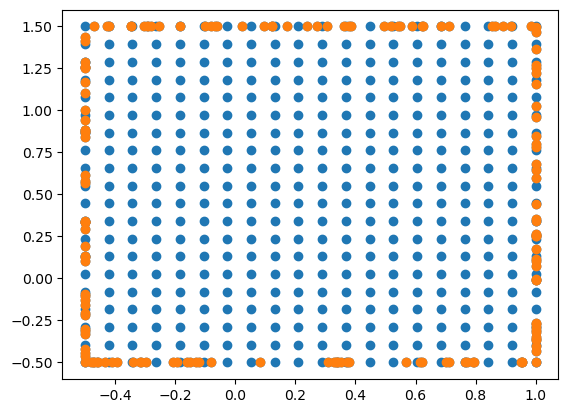

In [1]:
import sys
sys.path.append('../')

import copy

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import torch
import matplotlib

from user_funn.field import D2Field
from user_funn.get_net import ForwardNetwork
from user_funn.ds import get_data_loader
from user_funn.solver import CloudPointSolver
from user_funn.geom import line_sample
from user_funn.pde import diff
import user_funn.plot

np.random.seed(1)
torch.manual_seed(1)

# STEP0 定义解析解（同时也为边界条件的依据）
Re = 20
nu = 1 / Re
l = 1 / (2 * nu) - np.sqrt(1 / (4 * nu ** 2) + 4 * np.pi ** 2)

def u_func(x):
    return 1 - np.exp(l * x[:, 0:1]) * np.cos(2 * np.pi * x[:, 1:2])

def v_func(x):
    return l / (2 * np.pi) * np.exp(l * x[:, 0:1]) * np.sin(2 * np.pi * x[:, 1:2])

def p_func(x):
    return 1 / 2 * (1 - np.exp(2 * l * x[:, 0:1]))

# STEP1 data generate
batch_num = 4
nx = 20

pde_batch_size = nx * nx 
pde_epoch_size = pde_batch_size
field = D2Field([-0.5,1],[-0.5,1.5])
pde_input = field.get_field_mesh([nx,nx])
pde_output = np.zeros([pde_epoch_size,3])


bc_batch_size = nx * 2 #每条边上用点数量
bc_epoch_size = bc_batch_size
bc_left_x = line_sample([-0.5,-0.5],[-0.5,1.5], bc_epoch_size)
bc_up_x = line_sample([-0.5,1.5],[1,1.5], bc_epoch_size)
bc_right_x = line_sample([1,1.5],[1,-0.5], bc_epoch_size)
bc_down_x = line_sample([-0.5,-0.5],[1,-0.5], bc_epoch_size)
bc_input = np.vstack([bc_left_x, bc_up_x, bc_right_x, bc_down_x])
bc_output = np.zeros([bc_input.shape[0],3])

bc_output[:,0] = p_func(bc_input).squeeze()
bc_output[:,1] = u_func(bc_input).squeeze()
bc_output[:,2] = v_func(bc_input).squeeze()

pde_input = np.vstack([pde_input, bc_input])
pde_output = np.zeros([pde_input.shape[0],3])

user_funn.plot.scatter_2d_cloud_point_kind([pde_input,bc_input])

np.random.shuffle(pde_input)

pde_batch_size = pde_input.shape[0] // batch_num
bc_batch_size = bc_input.shape[0]// batch_num 


In [2]:
# STEP2 loss define
cloud_point_data = [[pde_input, pde_output],[bc_input, bc_output]]

loss_fn = torch.nn.MSELoss()

def grad(outputs, inputs):
    return torch.autograd.grad(outputs, inputs,
                               grad_outputs=torch.ones_like(outputs),
                               create_graph=True)


def pde_loss(model, data):
    x_in,y_real = data
    x_in.requires_grad=True

    x = x_in[:,[0]]
    y = x_in[:,[1]]
    x_use = torch.cat((x,y),dim = 1)
    U = model(x_use)
    p = U[:,[0]]
    u = U[:,[1]]
    v = U[:,[2]]

    dudx = diff(u,x)
    dudy = diff(u,y)
    dvdx = diff(v,x)
    dvdy = diff(v,y)
    dpdx = diff(p,x)
    dpdy = diff(p,y)

    du2dx2 = diff(dudx,x)
    du2dy2 = diff(dudy,y)
    dv2dx2 = diff(dvdx,x)
    dv2dy2 = diff(dvdy,y)

    eq1 = u * dudx + v * dudy + dpdx - 1 / Re * (du2dx2 + du2dy2)
    eq2 = u * dvdx + v * dvdy + dpdy - 1 / Re * (dv2dx2 + dv2dy2)
    eq3 = dudx + dvdy
    loss_val = loss_fn(eq1, y_real[:,[0]]) + loss_fn(eq2, y_real[:,[1]]) + \
        loss_fn(eq3, y_real[:,[2]])
    return loss_val

def data_loss(model, data):
    # 数据提取
    x_in,y_real = data
    U = model(x_in)
    loss_val = loss_fn(U, y_real)
    return loss_val

solver = CloudPointSolver(
    [[pde_input, pde_output],[bc_input, bc_output]],
    [pde_loss,data_loss],
    model = [2, 32,32,32,32,32, 3],
    optimizer = "adam",
    batchsize = [pde_batch_size,bc_batch_size])

for i in range(2000):
    solver.train_step()
    if i % 100 == 0:
        solver.test_step(print_flag=True)

print('train over')


loss is [0.00299713 1.6951076  1.6981046 ]
loss is [0.04064051 0.60069144 0.641332  ]
loss is [0.04766399 0.5459076  0.59357154]
loss is [0.05874002 0.4979663  0.5567063 ]
loss is [0.05851428 0.4751948  0.5337091 ]
loss is [0.05599068 0.45001006 0.50600076]
loss is [0.06502686 0.34722406 0.41225094]
loss is [0.02748705 0.04511678 0.07260382]
loss is [0.01488595 0.02138455 0.0362705 ]
loss is [0.01001917 0.01437125 0.02439042]
loss is [0.01203036 0.0103259  0.02235627]
loss is [0.00637964 0.00833853 0.01471817]
loss is [0.00407868 0.00549032 0.009569  ]
loss is [0.00450912 0.00435513 0.00886425]
loss is [0.00991184 0.00379434 0.01370618]
loss is [0.00767674 0.00272686 0.0104036 ]
loss is [0.00446438 0.00219447 0.00665885]
loss is [0.01103104 0.00217453 0.01320558]
loss is [0.01245432 0.00191245 0.01436678]
loss is [0.00488471 0.00146792 0.00635263]
train over


0.050775049025626406
0.06512708197996979
0.09048823684223928


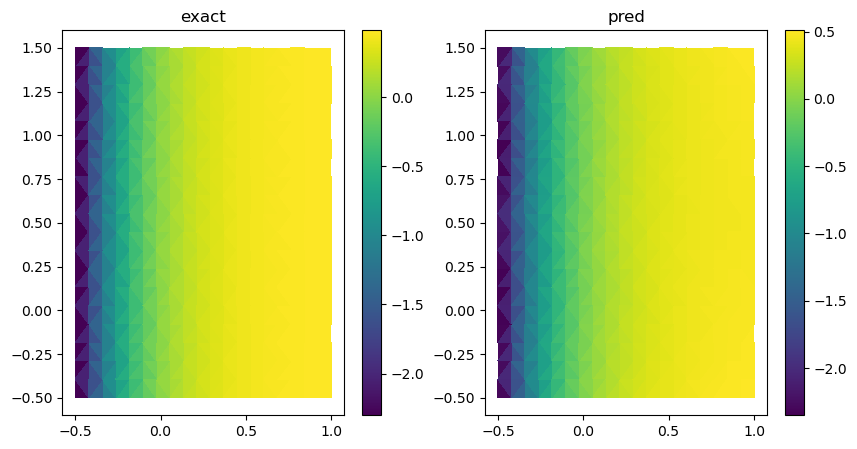

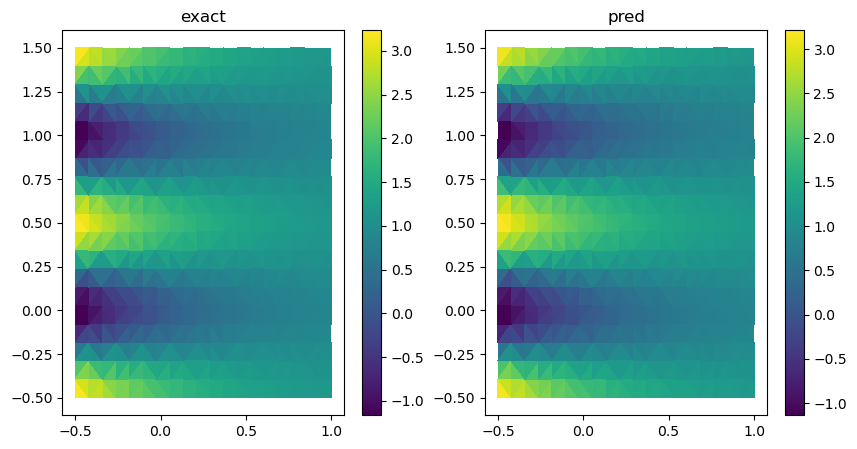

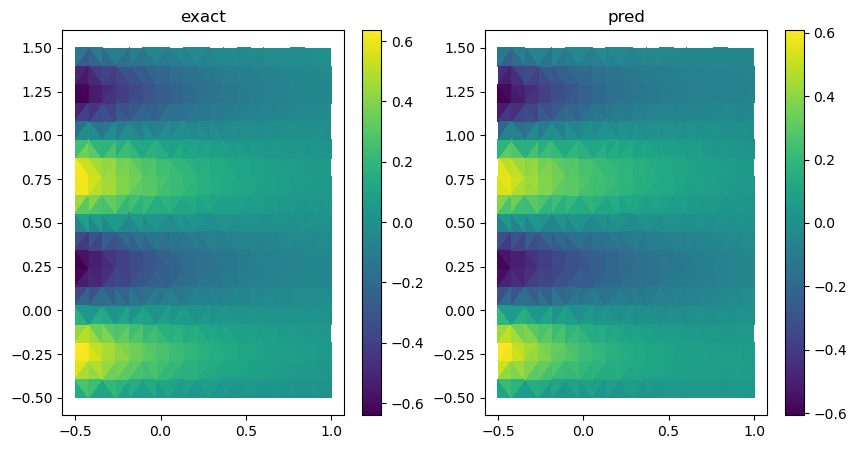

In [3]:
plot_input = field.get_field_mesh([nx,nx])
plot_output = solver.model_eval(plot_input)
plot_p = plot_output[:,0]
plot_u = plot_output[:,1]
plot_v = plot_output[:,2]
exact_p = p_func(plot_input)
exact_u = u_func(plot_input)
exact_v = v_func(plot_input)
import matplotlib.pyplot as plt
import matplotlib.tri as tri

def plot_U(x,y,u_exact,u_pred):
    fig,(ax1,ax2) = plt.subplots(1,2,figsize =[10,5] )

    triang = tri.Triangulation(x,y)
    tpc = ax1.tripcolor(triang,u_exact , shading='flat')
    fig.colorbar(tpc,ax=ax1)
    ax1.set_title('exact')

    tpc = ax2.tripcolor(triang,u_pred , shading='flat')
    fig.colorbar(tpc,ax=ax2)
    ax2.set_title('pred')
    print(np.mean(np.abs(u_exact-u_pred))/np.std(u_exact))

x = plot_input[:,0]
y = plot_input[:,1]
plot_U(plot_input[:,0], plot_input[:,1], exact_p.ravel(), plot_p)
plot_U(plot_input[:,0], plot_input[:,1], exact_u.ravel(), plot_u)
plot_U(plot_input[:,0], plot_input[:,1], exact_v.ravel(), plot_v)